In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.DEBUG)
# Uncomment the follwing line to enabled devlib debugging statements
#logging.getLogger('ssh').setLevel(logging.DEBUG)
#logging.getLogger('android').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import copy
import json
import os
import pexpect as pe

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Support for trace events analysis
from trace import Trace
from trace_analysis import TraceAnalysis
from filters import Filters

# Suport for FTrace events parsing and visualization
import trappy
import bart

# Support for DataFrames
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Target specific constants

In [3]:
# Ariel Energy Model
nrg_model = {
    "little" :  {
        "cpu" :  {
            "nrg_min" :  48,
            "nrg_max" : 217,
            "cap_min" : 204,
            "cap_max" : 519,
        },
        "cluster" : {
            "nrg_min" :  74,
            "nrg_max" : 220,
        },
    },
    "big" : {
        "cpu" : {
            "nrg_min" :  155,
            "nrg_max" : 1098,
            "cap_min" :  284,
            "cap_max" : 1024,
        },
        "cluster" : {
            "nrg_min" :  90,
            "nrg_max" : 252,
        }
    }
}

# Test environment setup

In [4]:
# Setup a target configuration
my_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',
    "board"       : 'n5x',
    
    # Results folder
    "results_dir" : "AndroidShadow",
    
    "nrg_model" : nrg_model,

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 194, '1': 193, '2': 191, '3': 191, '4': 75, '5': 75
    },

    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd', 'hwuitest64'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_idle",                                                                                                                                                                                                                                                    
            "cpu_capacity",
            "cpu_frequency",
            "sched_switch",
            "sched_overutilized",
            "sched_tune_boostgroup_update",
            "sched_tune_config",
            "sched_tune_filter",
            "sched_tune_tasks_update",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_energy_diff",
            "sched_contrib_scale_f"
         ],
         "buffsize" : 10240
    },

}


CATAPULT_HOME = '/media/derkling/Patbel01Disk/catapult'

In [5]:
# This is a configuraiton hack required just on Android devices using the
# CoPilot "performance manager". We need to enable all the CPUs to properly
# support:
# 1. loading of the 'bl' module, which requires at least a big and a LITTLE
#    CPU to be online at the initialization time
# 2. RTApp calibration
!adb root
# !sleep 2
# #!adb shell 'echo 4 2 > /proc/hps/num_base_perf_serv'
# !adb devices

adbd is already running as root


In [6]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration (my_test_conf)
te = TestEnv(my_conf)
target = te.target

10:47:33  INFO    :         Target - Using base path: /home/derkling/Code/lisa
10:47:33  INFO    :         Target - Loading custom (inline) target configuration
10:47:33  DEBUG   :         Target - Target configuration {'ftrace': {'buffsize': 10240, 'events': ['cpu_idle', 'cpu_capacity', 'cpu_frequency', 'sched_switch', 'sched_overutilized', 'sched_tune_boostgroup_update', 'sched_tune_config', 'sched_tune_filter', 'sched_tune_tasks_update', 'sched_boost_cpu', 'sched_boost_task', 'sched_wakeup', 'sched_wakeup_new', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_energy_diff', 'sched_contrib_scale_f']}, 'rtapp-calib': {'1': 193, '0': 194, '3': 191, '2': 191, '5': 75, '4': 75}, 'results_dir': 'AndroidShadow', 'platform': 'android', 'board': 'n5x', 'nrg_model': {'big': {'cluster': {'nrg_min': 90, 'nrg_max': 252}, 'cpu': {'nrg_min': 155, 'cap_min': 284, 'cap_max': 1024, 'nrg_max': 1098}}, 'little': {'cluster': {'nrg_min': 74, 'nrg_max': 220}, 'cpu': {'nrg_min': 48, 'cap_min': 204, 'cap_

In [7]:
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

10:47:45  INFO    : Target ABI: arm64, CPus: ['A57']


In [8]:
# Remount /system RW
target.execute("mount -o remount,rw /system");

10:47:45  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "mount -o remount,rw /system"


In [9]:
# Check which version we have installed
installed_atrace = target.get_installed('atrace')
md5sum = target.execute("md5sum {}".format(installed_atrace))
installed_md5 = md5sum.split()[0]
print "Installed ATrace : ", installed_md5
print "   ", installed_md5

# Compute md5 of local version
lisa_atrace = "../../tools/arm64/atrace"
md5sum = !md5sum {lisa_atrace}
lisa_md5 = md5sum[0].split()[0]
print "Lisa ATrace      : ", lisa_atrace
print "   ", lisa_md5

if lisa_md5 != installed_md5:
    print "Installing LISA provided atrace tool"
    target.execute("mv {0} {0}.bak".format(installed_atrace))
    target.push(lisa_atrace, installed_atrace)
else:
    print "Installed atrace matched LISA provided tool"

10:47:45  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "if [ -e '/data/local/tmp/bin' ]; then echo 1; else echo 0; fi"
10:47:45  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "ls /data/local/tmp/bin"
10:47:45  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "echo $PATH"
10:47:45  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "ls /sbin"
10:47:45  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "ls /vendor/bin"
10:47:45  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "ls /system/sbin"
10:47:45  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "ls /system/bin"
10:47:45  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "md5sum /system/bin/atrace"


Installed ATrace :  506f5c5ab449d12a75d472cd09f97bc7
    506f5c5ab449d12a75d472cd09f97bc7
Lisa ATrace      :  ../../tools/arm64/atrace
    506f5c5ab449d12a75d472cd09f97bc7
Installed atrace matched LISA provided tool


# Support Functions

## Experiments execution functions

In [10]:
SYSTRACE_CMD  = CATAPULT_HOME + "/systrace/systrace/systrace.py -o {} gfx view sched freq -t {}"
SYSTRACE_TIME = 5

def compare(tid, tcmd, collect='all', governors='all'):
    logging.info('Test case: %s (%s)', tid, tcmd)
    
    res_dir = os.path.join(te.res_dir, tid)
    logging.info('  results folder: %s', res_dir)
    
    # Run the workload in all the configured governors
    results[tid] = {}
    for governor in confs:
        if governors != 'all' and governor not in governors:
            continue
        exp_dir = os.path.join(res_dir, governor)
        res = experiment(governor, tcmd, exp_dir, collect)
        results[tid][governor] = copy.deepcopy(res)

def experiment(governor, tcmd, exp_dir, collect='all'):
    results = {}
    
    logging.info("Experiment: governor=%s, collect=%s", governor, collect)
    
    # Ensure all CPUs are online
    #target.execute('echo 4 2 > /proc/hps/num_base_perf_serv')
    
    os.system('mkdir -p {}'.format(exp_dir));
    results['exp_dir'] = exp_dir
    
    logging.info('------------------------')
    logging.info('Run workload: %s', tcmd)

    # Setup CPUFreq governor
    confs[governor]['set']()
    logging.info('    governor:\n%s',
                 json.dumps(target.cpufreq.get_all_governors(), indent=4))

    # Start the required tracing command
    if 'all' in collect or 'ftrace' in collect:
        # Start FTrace and Energy monitoring
        te.ftrace.start()
    elif 'systrace' in collect:
        # Start systrace
        results['trace_file'] = os.path.join(exp_dir, 'trace.html')
        systrace_cmd = SYSTRACE_CMD.format(
                                    results['trace_file'], SYSTRACE_TIME)
        logging.debug("SysTrace CMD: %s", systrace_cmd)
        systrace_output = pe.spawn(systrace_cmd)

    # Execte the workload
    output = target.execute(tcmd)

    # Stop the required trace command
    if 'all' in collect or 'ftrace' in collect:
        te.ftrace.stop()
    elif 'systrace' in collect:
        logging.info('Waiting systrace report [%s]...', results['trace_file'])
        systrace_output.wait()
    
    if 'all' in collect or 'stats' in collect:
        # Processing test resuts
        logging.info('Parsing experiment results...')
        df = dataframe(output)
        results['df'] = df
    
        # Computing stats
        logging.info('Computing execution stats...')
        results['stats'] = stats(df)
    
    # Dump platform description
    te.platform_dump(exp_dir)
    
    # Collect and keep track of the trace
    if 'all' in collect or 'ftrace' in collect:
        logging.info('Collecting FTrace events...')
        trace_file = os.path.join(exp_dir, 'trace.dat')
        te.ftrace.get_trace(trace_file)
        results['trace_file'] = trace_file        
    
    # Parse trace
    if 'all' in collect or 'trace_analysis' in collect:
        logging.info('Trace analysis...')
        tr = Trace(te.platform, results['trace_file'],
                   events=my_conf['ftrace']['events'],
                   trace_format='SysTrace')
        results['trace'] = tr
        results['ftrace'] = tr.ftrace
        results['ta'] = TraceAnalysis(tr, te.platform)
    
        # return all the experiment data
    return results

def set_performance():
    target.cpufreq.set_all_governors('performance')
    
def set_powersave():
    target.cpufreq.set_all_governors('powersave')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    # Configure the MAX sampling rate supporte by the LITTLE cores
    littles_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.littles[0])
    target.cpufreq.set_governor_tunables(
        target.bl.littles[0], 'ondemand',
        **{'sampling_rate' : littles_tunables['sampling_rate_min']}
    )
    
    # Configure the MAX sampling rate supporte by the big cores
    bigs_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.bigs[0])
    target.cpufreq.set_governor_tunables(
        target.bl.bigs[0], 'ondemand',
        **{'sampling_rate' : bigs_tunables['sampling_rate_min']}
    )
    
def set_interactive():
    target.cpufreq.set_all_governors('interactive')
   

## Collected data analysis and plotting functions

In [11]:
def dataframe(results):
    stats = {}
    for line in results.splitlines():
        if ':' not in line:
            continue
        k, v = line.split(':')
        
        v = v.replace('ns', '')
        v = v.replace('ms', '')
        v = v.translate(None, ':()%')

        #print "{:25} : {}".format(k,v)
    
        if k not in stats:
            stats[k] = []
        if k == "Janky frames":
                v1, v2 = v.split()
                stats[k].append(float(v1))
                k2 = k+' pct'
                if k2 not in stats:
                    stats[k+' pct'] = []
                stats[k+' pct'].append(float(v2))
        else:
            stats[k].append(float(v))
    #print json.dumps(stats, indent=4)

    df = pd.DataFrame.from_dict(stats)
    return df

def stats(df):
    return df.mean()[['Janky frames pct', 'Number Missed Vsync']]

def reportPlot(tid, collect):
    global results
    
    templates = [trappy.sched.SchedLoadAvgCpu, trappy.sched.SchedCpuCapacity]
    column = ["util_avg", "state"]
    for governor in confs:
        if governor not in results[tid]:
            continue
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['ftrace'],
                        templates,
                        column=column,
                        pivot="cpu",
                        #filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
    
def reportTracePlots(tid, select):
    global results
    filters = None
    
    pd.options.mode.chained_assignment = None  # default='warn'

    # Plot Custer Frequencies and report averate frequencies
    for governor in confs:
        if governor not in results[tid]:
            continue
        plot_title = "Cluster frequencies, {}".format(governor.upper())
        ta = results[tid][governor]['ta']
        logging.info("%s:", plot_title)
        ta.plotClusterFrequencies(title=plot_title)
        
    # Plot topBigTasks
    for governor in confs:
        if governor not in results[tid]:
            continue
        if filters is None:
            trace = results[tid][governor]['trace']
            filters = Filters(trace)
        
        LITTLE_MAX_CAPACITY=nrg_model['little']['cpu']['cap_max']
        BIG_MIN_CAPACITY=nrg_model['big']['cpu']['cap_min']
        plot_title = "Top big tasks, {}".format(governor.upper())
        print plot_title
        filters.topBigTasks(min_utilization=BIG_MIN_CAPACITY)
        filters.plotBigTasks(min_utilization=BIG_MIN_CAPACITY)

    # Plot top Wakeup tasks
    for governor in confs:
        if governor not in results[tid]:
            continue
        if filters is None:
            trace = results[tid][governor]['trace']
            filters = Filters(trace)
        
        plot_title = "Top wakeup tasks, {}".format(governor.upper())
        print plot_title
        filters.topWakeupTasks()
        filters.plotWakeupTasks()
        filters.plotWakeupTasks(per_cluster=True)
        
    # Plot Tasks vs Frequency
    for governor in confs:
        if governor not in results[tid]:
            continue
        if filters is None:
            trace = results[tid][governor]['trace']
            filters = Filters(trace)
        
        plot_title = "Tasks vs Frequency, {}".format(governor.upper())
        print plot_title
        print filters.plotTasksVsFrequency()

    # Report RT tasks
    #for governor in confs:
    #    if governor not in results[tid]:
    #        continue
    #    if filters is None:
    #        trace = results[tid][governor]['trace']
    #        filters = Filters(trace)
    #    plot_title = "RT Tasks, {}".format(governor.upper())
    #    print plot_title
    #    filters.rtTasks()

        
def reportStats(tid, select):
    global results

    # Plot Custer Frequencies and report averate frequencies
    for governor in confs:
        if governor not in results[tid]:
            continue
        st = results[tid][governor]['stats']
        print
        print "Stats, {}".format(governor.upper())
        print st
    
def report(tid, select='all'):
    if 'all' in select or 'ftrace' in select:
        reportPlot(tid, select)
    if 'all' in select or 'ftrace' in select:
        reportTracePlots(tid, select)
    if 'all' in select or 'stats' in select:
        reportStats(tid, select)
        
        
def getFTrace(tid, governor):
    return results[tid][governor]['ftrace']

## Target configurations to explore

In [12]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
#     'powersave' : {
#         'label' : 'sch',
#         'set' :  set_powersave,
#     },
    'sched' : {
        'label' : 'sch',
        'set' :  set_sched,
#     },
#     'ondemand' : {
#         'label' : 'odm',
#         'set' :  set_ondemand,
#    },
#    'interactive' : {
#        'label' : 'itr',
#        'set' :  set_interactive,
    }
}

# The set of results forlder for each comparition test
results = {}

# Test: ShadowGrid2

In [13]:
hwuitest64 = target.get_installed('hwuitest64')
print hwuitest64

10:47:46  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "if [ -e '/data/local/tmp/bin' ]; then echo 1; else echo 0; fi"
10:47:46  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "ls /data/local/tmp/bin"


/data/local/tmp/bin/hwuitest64


## Stats on multiple run executions

In [15]:
# Define a label for this test case
test_case = 'shadowgrid2'
test_cmd  = '{} {}'.format(hwuitest64, 'shadowgrid2 10')
features = 'stats'

# Run this workload in all the configurations
compare(test_case, test_cmd, collect=features)

10:11:21  INFO    : Test case: shadowgrid2 (/data/local/tmp/bin/hwuitest64 shadowgrid2 10)
10:11:21  INFO    :   results folder: /home/derkling/Code/lisa/results/AndroidShadow/shadowgrid2
10:11:21  INFO    : Experiment: governor=performance, collect=stats
10:11:21  INFO    : ------------------------
10:11:21  INFO    : Run workload: /data/local/tmp/bin/hwuitest64 shadowgrid2 10
10:11:21  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "echo '/data/local/tmp/bin/shutils cpufreq_set_all_governors performance' | su"
10:11:22  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "echo '/data/local/tmp/bin/shutils cpufreq_get_all_governors' | su"
10:11:22  INFO    :     governor:
{
    "1": "performance", 
    "0": "performance", 
    "3": "performance", 
    "2": "performance", 
    "5": "performance", 
    "4": "performance"
}
10:11:22  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "/data/local/tmp/bin/hwuitest64 shadowgrid2 10"
10:11:48  INFO    : Parsing experiment results...
10:11:48  INFO    : Computing executi

In [16]:
report(test_case, select=features)


Stats, PERFORMANCE
Janky frames pct       11.533
Number Missed Vsync     0.000
dtype: float64

Stats, SCHED
Janky frames pct       21.932
Number Missed Vsync     0.000
dtype: float64

Stats, POWERSAVE
Janky frames pct       84.26
Number Missed Vsync     0.00
dtype: float64


## Trace analysis on SchedDVFS (single run)

In [14]:
# Define a label for this test case
test_case = 'shadowgrid2'
test_cmd  = '{} {}'.format(hwuitest64, 'shadowgrid2 1')
features = 'systrace_analysis'

# Run this workload in all the configurations
compare(test_case, test_cmd, collect=features, governors='sched')

10:47:48  INFO    : Test case: shadowgrid2 (/data/local/tmp/bin/hwuitest64 shadowgrid2 1)
10:47:48  INFO    :   results folder: /home/derkling/Code/lisa/results/AndroidShadow/shadowgrid2
10:47:48  INFO    : Experiment: governor=sched, collect=systrace_analysis
10:47:49  INFO    : ------------------------
10:47:49  INFO    : Run workload: /data/local/tmp/bin/hwuitest64 shadowgrid2 1
10:47:49  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "echo '/data/local/tmp/bin/shutils cpufreq_set_all_governors sched' | su"
10:47:49  DEBUG   : adb -s 00b43d0b08a8a4b8 shell "echo '/data/local/tmp/bin/shutils cpufreq_get_all_governors' | su"
10:47:49  INFO    :     governor:
{
    "1": "sched", 
    "0": "sched", 
    "3": "sched", 
    "2": "sched", 
    "5": "sched", 
    "4": "sched"
}
10:47:49  DEBUG   : SysTrace CMD: /media/derkling/Patbel01Disk/catapult/systrace/systrace/systrace.py -o /home/derkling/Code/lisa/results/AndroidShadow/shadowgrid2/sched/trace.html gfx view sched freq -t 5
10:47:49  DEBUG  

Maximum estimated system energy: 3536


In [15]:
report(test_case, select=features)

In [16]:
ftrace = getFTrace(test_case, 'sched')

In [17]:
trappy.plotter.plot_trace(ftrace)

## Render thread analysis

In [18]:
trappy.plotter.plot_trace(ftrace, execnames=['RenderThread'])

## Big tasks analysis

06:17:54  INFO    : Set plots time range to (0.000000, 5.000192)[s]


Total 85 tasks with at least 100 "utilization" samples > 100
Top 10 "big" tasks:
     count unique              top freq
pid                                    
8389   839      1     RenderThread  839
8398   331      4  tbrite.attendee  317
8392   105      1        hwuiTask1  105
Tasks which have been a "utilization" of 519 for at least 100 samples

/home/derkling/.local/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/derkling/.local/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
06:17:55  WARNING : Events [cpu_frequency] not found, plot DISABLED!


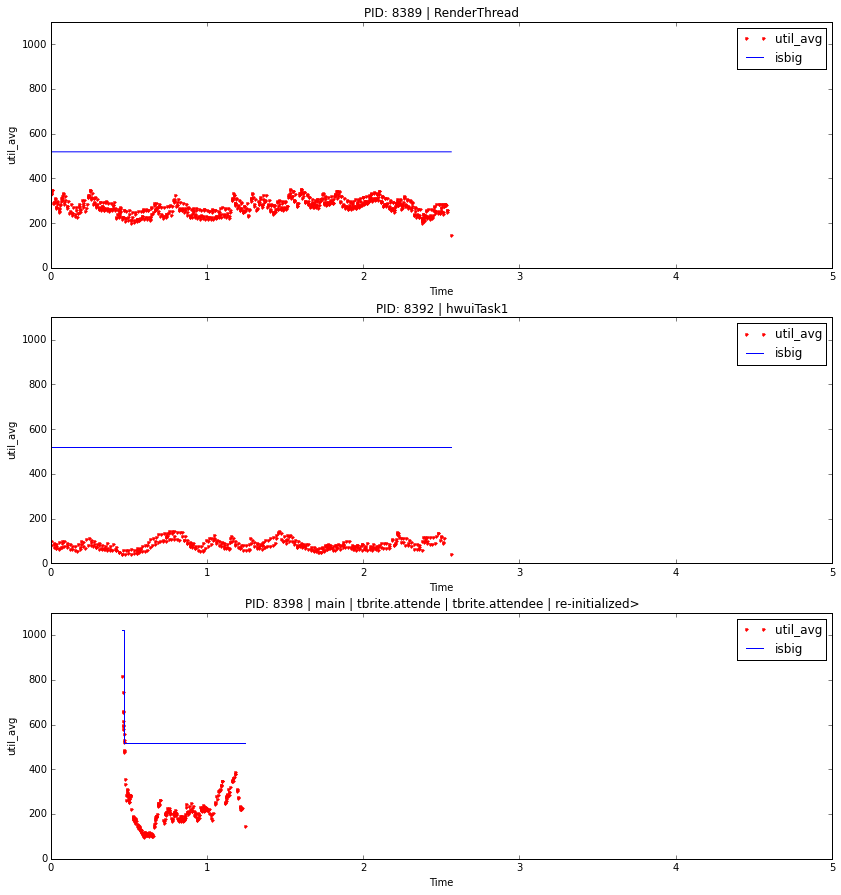

In [18]:
trace = results[test_case]['sched']['trace']
filters = Filters(trace)
        
filters.topBigTasks(min_utilization=100)
filters.plotBigTasks(min_utilization=100)


ta = results[test_case]['sched']['ta']
ta.plotClusterFrequencies()

In [20]:
trappy.plotter.plot_trace(ftrace, execnames=['surfaceflinger'])

## Boosted tasks analysis

In [22]:
boost_events = ftrace.sched_boost_task.data_frame
boost_events.head()

,__comm,__cpu,__pid,comm,margin,pid,util,boosted_util
Time,,,,,,,,
0.000047,<idle>,1,0,ksoftirqd/1,0,12,3,3
0.000058,ksoftirqd/1,1,12,rcu_preempt,0,8,8,8
0.000060,ksoftirqd/1,1,12,rcu_preempt,0,8,8,8
0.000062,ksoftirqd/1,1,12,rcu_preempt,0,8,8,8
0.000063,ksoftirqd/1,1,12,rcu_preempt,0,8,8,8


In [24]:
boosted_tasks = boost_events[boost_events.margin != 0][['pid', 'comm', 'util', 'boosted_util']]
logging.info("Boos events:")
boosted_tasks.head()

06:19:11  INFO    : Boos events:


,pid,comm,util,boosted_util
Time,,,,


In [25]:
little_max_cap = nrg_model['little']['cpu']['cap_max']
logging.info("Boost events exceeding the LITTLE capacity:")
big_boosted_tasks = boosted_tasks[boosted_tasks.boosted_utilization > little_max_cap]
big_boosted_tasks.head()

06:19:43  INFO    : Boost events exceeding the LITTLE capacity:


AttributeError: 'DataFrame' object has no attribute 'boosted_utilization'

In [26]:
# Define the aggregation calculations
aggregations = {
    'utilization': {
        'min'  : 'min',
        'avg'  : 'mean',
        'max'  : 'max',
    },
    'boosted_utilization': {
        'min'  : 'min',
        'avg'  : 'mean',
        'max'  : 'max',
    },
    'pid': ['count'],
    'comm' : {
        'task_name' : 'max'
    }
}
big_boosted_tasks_stats = big_boosted_tasks.groupby('pid').agg(aggregations)
big_boosted_tasks_stats

NameError: name 'big_boosted_tasks' is not defined

In [27]:
logging.info("Tasks running on big CPUs")
switch_events = ftrace.sched_switch.data_frame
switch_events.head()

06:19:46  INFO    : Tasks running on big CPUs


,__comm,__cpu,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,
0.000019,atrace,1,8390,swapper/1,0,120,atrace,8390,120,S
0.000049,<idle>,1,0,ksoftirqd/1,12,120,swapper/1,0,120,R
0.000093,<idle>,2,0,rcu_preempt,8,120,swapper/2,0,120,R
0.000101,ksoftirqd/1,1,12,swapper/1,0,120,ksoftirqd/1,12,120,S
0.000117,rcu_preempt,2,8,swapper/2,0,120,rcu_preempt,8,120,S


In [28]:
switch_event[switch_events.__cpu ]

NameError: name 'switch_event' is not defined

In [ ]:
trace = results[test_case]['sched']['trace']

In [ ]:
trace.getTasks()

In [ ]:
print results[test_case]['sched']['trace_file']

In [ ]:
!ls -la /home/patbel01/Code/schedtest/results/20151125_163250/shadowgrid2/sched/trace.dat